TODO: parameters knn, reg tree, heuristic? reg tree

data: what we will predict

data splitting

# Question 3

**How does the decision tree regressor model compare to the k-nearest neighbour regressor model in terms of in- and out-of-sample error for time series forecasting?**

Decision tree regression (DTR) and K-neirest neighbor (KNN) are two techniques for solving regression problems. Both models have the great advantage of being transparant in how predications are obtained. They, however, differ vastly in the way their regression hypothesis is obtained. DTR makes its predictions based on a model it learned, while KNN does not learn a model at all, the data is the model. 

In this section we will compare the two techniques on a real world data set in terms of in- and out-of-sample error. Let us first get a better understanding of the workings of these two techniques.



# Decision tree regression

Decision trees have implementations both for classification (classification trees) and for regression (regression trees). In what follows we will explain the workings of the regression case. The decision tree algorithm produces a model that can be used for predictions. Given an input $\mathbf{x}$, the model obtains a prediction $\hat y$ by following a series of decision rules. 

The model can be represented as a tree, where each **internal node** corresponds to a decision. Internal nodes have one incoming edges and out-going edges, labeled with the choise of a decision. The **leaf nodes** represent the final outcome of the perdiction ($\hat y$). In the classification case, those outcomes are categorical, while in the regression case, the leaves represent a numeric value.

By starting from the **root node** and following the path to a leaf node, a $\hat y$ value can be obtained given an input $\mathbf{x}$. The image below displays an example of a regression tree.

<img src="https://www.researchgate.net/profile/Fritz-Schiltz-2/publication/325712556/figure/fig1/AS:636637654552580@1528797653733/Example-of-a-regression-tree-Panel-a-with-the-partition-of-the-covariates-space-Panel.png" alt="Example of a regression tree (Panel a), with the partition of the... |  Download Scientific Diagram" width=400 />

Source: [(PDF) Using Regression Tree Ensembles to Model Interaction Effects: A Graphical Approach (researchgate.net)](https://www.researchgate.net/publication/325712556_Using_Regression_Tree_Ensembles_to_Model_Interaction_Effects_A_Graphical_Approach/figures?lo=1)



Let us now invastigate how the algorithm works to obtain its regression trees. We will explain this by means of an example. We must predict the weight of people given their height, shoe size and gender. 
$$
\mathbf{x} = \text{<?height, ?shoe size, ?gender>}
\newline
y = \text{?weight}
$$
To build the decision tree, the algorithm must first decide on what its root node should be. Lets assume a node contains the following structure: "X is less than y", where X corresponds to a feature of the dataset and y corresponds to a certain treshold. An example node could then be: " *weight is less than 45*".  When deciding upon a node, there are two questions to ask, 1)  What should the threshold be? and 2) What feature should we use? (eg: weight or shoe size) 

1. **What should the threshold be?**

   A plot of the height in relationship to the weight may look something like this:

   ![image-20220602194437933](https://i.imgur.com/tQcFrFR.png)

   Source: [The Relationship Between Human Height and Weight – GeoGebra](https://www.geogebra.org/m/RRprACv4)

   

   To select the optimal threshold, the data is split into two halfs, from each half the mean is calculated. For each data point the distance is calculated to its respective mean, this is called the residual. By squaring those residuals and summing them up the squared residuals are obtained. The objective is to minimize the sum of squared residuals. We demonstrate this in the following example.

   In the graph, a potential treshold could for example be right in the middle at height = 55 inches. Splitting the data into two parts at height = 55 and calculating the mean weight values of the data points on the left side and the mean of the data poitns on the right side may look as follows:

   ![image-20220602195415563](https://i.imgur.com/rcQwnDm.png)

   The sum of squared residuals on the left side will be rather small for the left side, however the sum of squared residuals on the right side will be larger. This is because sum of the y-distance to the left mean is smaller than the sum of y-distances to the right mean. If we calculate the sum of the left and right residuals, we may not have minimized it in this case.

   However, if we had selected a different threshold (eg height = 65), the sum of squared residuals on the left side may be a little bit higher, but the total sum of squared errors (left + right) will be lower! This is thus a better threshold.

   ![image-20220602195934856](https://i.imgur.com/S8RBFDU.png)

    The algorithm selects the threshold that minimizes the total sum of squared errors.

   

2. **What feature should we use?**

   Similar to what we have done to obtain the perfect threshold, the best feature is selected by trying out different thresholds and selecting the feature that has the smallest sum of squared residuals. 

   Note that this strategy also works for categorical values. To obtain the best sum of squared residuals for gender for example, there is only one threshold to be tested.

   ![image-20220602203133222](https://i.imgur.com/SjFy4mo.png)



**Overfitting**

The default behaviour of the decision tree regressor is to keep splitting the data into smaller groups until they can not be split any further. (Eg: all data points that correspond to a particular leave have the same value as the mean). This will cause the model to perfectly fit the training data, but the model will be severly overfit. This overfitting can be mitigated by setting a minimum on the number of data points that belong to a particular group. What is often done for example, is to set the minimum number to 20 for each leave. If a node has less than 20 data points, it will not be split further and instead take the mean of those data points as its output. By doing we, we limit how deep branches of the tree can grow.

The image below displays the predictions of two regression tree models that were trained on a noisy sine wave. What we can see that the result of decision tree regression is not a smooth continuous function such as a polynomial, but instead a function with many straight edges. This comes from the fact that similar data points are grouped the average of their target values is taken. Here we can also see how limiting the depth of the tree, will cause more elements to be grouped together, which prevents overfitting.



![../_images/sphx_glr_plot_tree_regression_001.png](https://scikit-learn.org/stable/_images/sphx_glr_plot_tree_regression_001.png)

Source: [1.10. Decision Trees — scikit-learn 1.1.1 documentation](https://scikit-learn.org/stable/modules/tree.html#tree)



Although, model predictions are really fast (logarithmic in the number of data points used to train the tree), one of the disadvanges of decision trees are that they take a long time to train. Learning an optimal decision tree is an NP-complete problem and thus decision-tree learning is based on greedy heuristics algorithms that do not guarantee a global optimal solution. We will see that K-NN mitigates this problem by not training a model at all.

Source: [1.10. Decision Trees — scikit-learn 1.1.1 documentation](https://scikit-learn.org/stable/modules/tree.html#tree)



# KNN regression

Just like decision trees, KNN can be used for both classification and regression. KNN, however, differs vastly from decision trees in the way the predictions are obtained. Instead of training a model and letting the model do the predications, in KNN the data is the model. 

KNN has the advantage that it is a lot simpler than decision trees. The idea behind KNN is that given an input $\mathbf{x}$, the target value $y$ is obtained by looking at all k data points in $\mathbf{x}$'s neighborhoud. This neighborhood contains all the k data points that are the most similar to $\mathbf{x}$. The output of the KNN algorithm depends on whether it is doing classificaiton or regression.  In the case of classification, the target value for $\mathbf{x}$ is obtained by selecting the mode of the target values in its neighborheid. In the regression case, the average value of the neighborhood's target values is selected as output. 

The image below visually illustrates the workings of the KNN algorithm. In the example k = 1 and thus the neighborhood only contains one point. The algorithm would thus select the target value of the star within the circle as its output for $\mathbf{x}$.

![image-20220602211346211](https://i.imgur.com/2cBh9vx.png)

Source: [KNN Classification Tutorial using Sklearn Python | DataCamp](https://www.datacamp.com/tutorial/k-nearest-neighbor-classification-scikit-learn)


The distance can be calculated via different metrics:

- **Minkowski Distance**
  $$
  d(\mathbf{x}, \mathbf{y}) =(\sum_{i=1}^n\left| x_i - y_i \right| ^p)^\frac{1}{p}
  $$
  The parameter $p$ allows us to manipulate the behaviour of the distance function. For example, when $p$ is set equal to 2, the distance corresponds to the euclidian distance. If $p$ is set to 1, the result corresponds to manhattan distance.

  

- **Euclidean Distance**
  $$
  d(\mathbf{x}, \mathbf{y}) = \sqrt{\sum_{i=1}^{n}{{(x_i - y_i)^2}}}
  $$
  

- **Manhattan Distance**
  $$
  d(\mathbf{x}, \mathbf{y}) = \sum_{i=1}^{n}{{\left|x_i - y_i\right|}}
  $$
  

  The image below graphically displays the difference between the manhattan and euclidian distance metrics. 

  ![Manhattan Distance Calculator](https://uploads-cdn.omnicalculator.com/images/manhattan_distance.png?width=425&enlarge=0&format=jpeg)



The neirest neighbors can be computed using different algorithms. Sklearn offers BallTree, KDTree or a brute for search. These are algorithms used to structure data in multidimensional space. Both the BallTree and KDTree algorithms structure their data in the form of a tree. Both algorithms require a leaf size parameter, which inffluences the speed of construction and the required memory of the tree.

### Training data description

To investigate the research question, we use a Kaggle dataset containing many in-house measurements of temperatures and humanities, as well as weather data and appliances energy consumption. For our goal, we focus
on predicting the humidity in the kitchen (in percentages) based on the other measurements.

The data contains 15000 measurements from the period: 01/11/2016 until 24/04/2016 of one house. These are measurements of four months, of 105 different day. Each day contains 144 measure. This is one measure every ten minutes.<br>
Below, a table can be seen that shows the data we are given. All the features contain numbers, except the feature "date" which is of the type datetime. This must be taken into consideration when feeding a model with this data. Not every model is can handle the datetime, so we will adapt it.

| | Column | Data type |
| --- | --- | --- |
| 1  |  date |          datetime |
| 2  |  T1 - T9 |       float64 |
| 3  |  RH_1 - RH_9 |   float64 |
| 20 |  T_out |         float64 |
| 21 |  Press_mm_hg |   float64 |
| 22 |  RH_out |        float64 |
| 23 |  Windspeed |     float64 |
| 24 |  Visibility |    float64 |
| 25 |  Tdewpoint |     float64 |
| 26 |  rv1 |           float64 |
| 27 |  rv2 |           float64 |
| 28 |  lights |        int64 |
| 29 |  Appliances |    int64 |

### Initialisation

We set up some utility functions to create plots of the humidity over time and per hour and include the used datascience libraries.

In [1]:
import warnings

import pandas as pd
import sklearn.base

warnings.filterwarnings('ignore')
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV
from time import time
import matplotlib.pyplot as plt


In [2]:
def plot_months(ax: plt.Axes, column: pd.DataFrame, label: str) -> None:
	"""
	Plot a data column for two months
	:param ax: Pyplot axis
	:param column: data column to plot
	:param label: label for the plot
	:return: None
	"""
	ax.plot(column, label=label)
	ax.set_xlabel("Time")
	ax.set_ylabel("Kitchen humidity (%)")


def plot_hours(ax: plt.Axes, data: pd.DataFrame, column: str) -> None:
	"""
	Plot boxplots of the data column for every hour
	:param ax: Pyplot axis
	:param data: dataframe
	:param column: column inside dataframe to plot
	:return: None
	"""
	data.boxplot(column=[column], by='hour', ax=ax)
	ax.set_xlabel("Hours")
	ax.set_ylabel("Kitchen humidity (%)")

### Dataset preprocessing and exploring

We read in the relevant dataset columns. _RH_1_ is the column containing kitchen humidity values which we want to predict.

In [3]:
# Columns to read in
columns = [
	"date",
	"lights",
	"T1", "RH_1",
	"T2", "RH_2",
	"T3", "RH_3",
	"T4", "RH_4",
	"T5", "RH_5",
	"T6", "RH_6",
	"T7", "RH_7",
	"T8", "RH_8",
	"T9", "RH_9",
	"T_out",
	"Press_mm_hg",
	"RH_out",
	"Windspeed",
	"Visibility",
	"Tdewpoint",
	"Appliances"
]

In [4]:
# To make this command work, 1) make sure you pip installed kaggle and 2) have a kaggle.json file in the correct directory.
# More information on the kaggle.json file can be found here: https://www.kaggle.com/docs/api
!kaggle datasets download -d loveall/appliances-energy-prediction

from zipfile import ZipFile
zf = ZipFile('appliances-energy-prediction.zip')
zf.extractall('data-rq-3/') #save files in selected folder
zf.close()


# In case doing the kaggle.json setup is too much work, you can just download the csv manually from: https://www.kaggle.com/datasets/loveall/appliances-energy-prediction
# Just make sure the KAG_energydata_complete.csv file is then saved in the directory: data-rq-3/
data = pd.read_csv("data-rq-3/KAG_energydata_complete.csv", header=0, usecols=columns)
data


  0%|          | 0.00/1.71M [00:00<?, ?B/s]
 58%|#####8    | 1.00M/1.71M [00:00<00:00, 3.33MB/s]
100%|##########| 1.71M/1.71M [00:00<00:00, 4.31MB/s]
100%|##########| 1.71M/1.71M [00:00<00:00, 4.08MB/s]


,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
0,2016-01-11 17:00:00,60,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,...,18.2000,48.900000,17.033333,45.5300,6.600000,733.5,92.000000,7.000000,63.000000,5.300000
1,2016-01-11 17:10:00,60,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,...,18.2000,48.863333,17.066667,45.5600,6.483333,733.6,92.000000,6.666667,59.166667,5.200000
2,2016-01-11 17:20:00,50,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,...,18.2000,48.730000,17.000000,45.5000,6.366667,733.7,92.000000,6.333333,55.333333,5.100000
3,2016-01-11 17:30:00,50,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,...,18.1000,48.590000,17.000000,45.4000,6.250000,733.8,92.000000,6.000000,51.500000,5.000000
4,2016-01-11 17:40:00,60,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,...,18.1000,48.590000,17.000000,45.4000,6.133333,733.9,92.000000,5.666667,47.666667,4.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,...,24.7000,50.074000,23.200000,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333
19731,2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,...,24.7000,49.790000,23.200000,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000
19732,2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,...,24.7000,49.660000,23.200000,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667
19733,2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.700000,...,24.6625,49.518750,23.200000,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333


The table contains over 5 months worth of measurements taken every 10 minutes. To speed up the training and prediction process for the experiments we limit ourselves to the first 2 full months. We also resample the time series to contain hourly measurements to smooth out very harsh fluctuations in humidity.<br>
Since the models that we want to compare don't support datetime values, we split this column into three separate numerical month, day and hour columns. Using our existing knowledge about humidity, it is a reasonable assumption that these features 
might have a significant impact on the variable to be predicted.

In [5]:
# Select the first two months of measurements
data = data[(data['date'] > '2016-02-01 00:00:00') & (data['date'] < '2016-04-01 00:00:00')]

# Split the date column into two month, day and hour columns
data['date'] = pd.to_datetime(data['date'])
data["month"] = pd.to_numeric(data["date"].dt.strftime("%m"))
data["day"] = pd.to_numeric(data["date"].dt.strftime("%d"))
data["hour"] = pd.to_numeric(data["date"].dt.strftime("%H"))

# Set the date column to be the index and resample the time series to hourly data
data = data.set_index('date')
data = data.resample("60T").mean()

We split the time series into a training and testing set by taking the first 75% of the data as training data and the last 25% as test data. No shuffling is done as we want to predict future values only.

In [6]:
# Split training and test data
train_data, test_data = train_test_split(data, shuffle=False)
# Remove/add the humidity value to be predicted
X_train = train_data.drop(["RH_1"], 1)
y_train = train_data["RH_1"]
X_test = test_data.drop(["RH_1"], 1)
y_test = test_data["RH_1"]

We plot the kitchen humidity values over time available in our training set. We can see they range between 32.5 and 52.5% and are quite erratic at first sight at this scale. A general downward trend can be observed with a peak in the middle. The values after 15/03 seem to have made an unexpected jump.

Text(0.5, 1.0, 'Kitchen humidity over time (training dataset)')

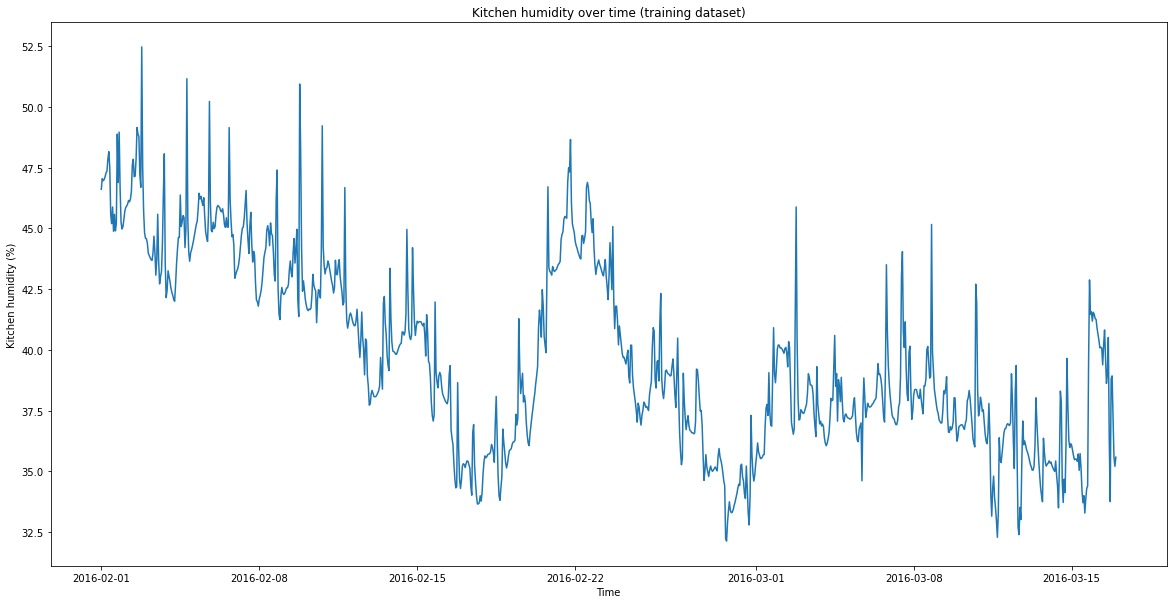

In [7]:
# Plot the training kitchen humidity over time
fig, ax = plt.subplots(figsize=(20, 10))
plot_months(ax, train_data["RH_1"], "Actual humidity")
ax.set_title("Kitchen humidity over time (training dataset)")

To investigate the influence of the passing of the day in hours on the humidity values, we create an hourly boxplot over the training data. We observe that the variation in humidity in general stays similar but rises in the afternoon and evening. Exceptionally higher humidity values are observed at 19h.

Text(0.5, 0.98, 'Kitchen humidity per hour (training dataset)')

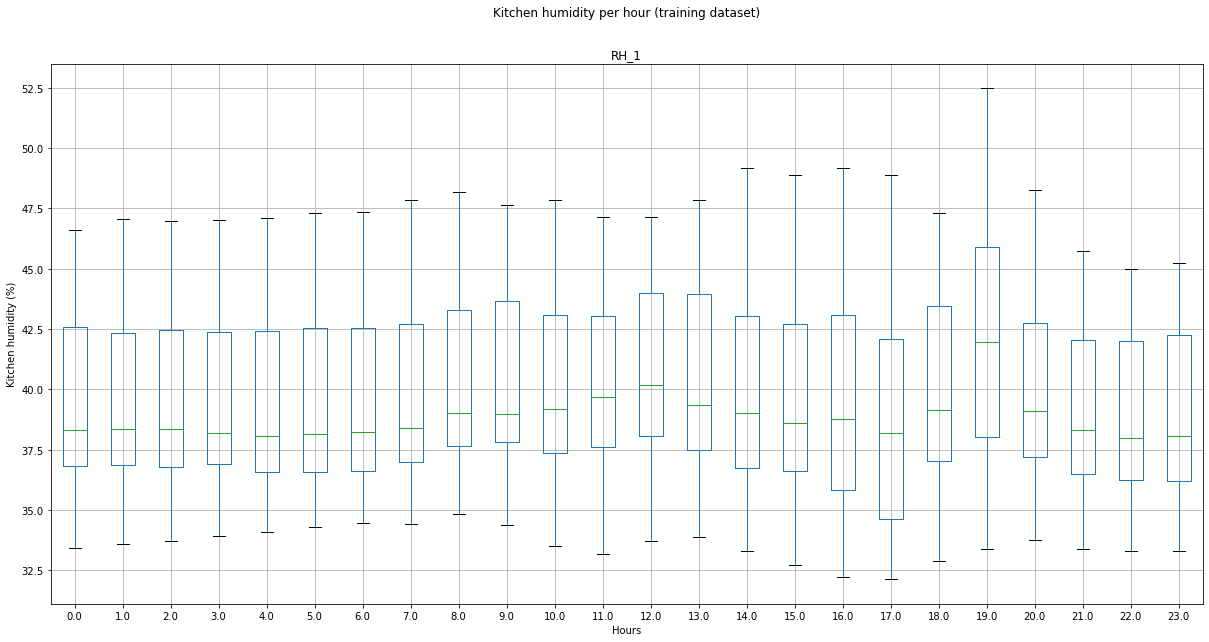

In [8]:
# Plot the training kitchen humidity variation every hour
fig, ax = plt.subplots(figsize=(20, 10))
plot_hours(ax, train_data, "RH_1")
fig.suptitle("Kitchen humidity per hour (training dataset)")

### Training, Testing and Validating

We set up the experiment by creating multiple functions to help us train and evaluate models and to parameter selection using cross-validation.<br>
The first function aids in measuring the training and test score and error. As this is a regression problem we use the root-mean-square error
$$E = \sqrt{\dfrac{\sum_{n=0}^N (y_n - h(x_n))^2}{N}}$$
The score is then calculated as follows
$$1-\dfrac{\sum_{n=0}^N (y_n - h(x_n))^2}{\sum_{n=0}^N (y_n - \bar{y})^2}$$
for mean $\bar{y}$. The best possible score is thus 1 but the score may also be negative when the model performs worse than predicting the average $\bar{y}$ over the training set. This function then also makes some comparative plots.<br>
The second function creates and evaluates a baseline model with normalisation where the default hyperparameters are used.<br>
The third function does a randomized grid search over a parameter grid by sampling a certain number of configurations at random without replacement. Note that the grid search makes use of cross-validation. 

The objective of k-fold cross validation is to better approximate $E_{\text{out}}$ by calculating multiple instances of $E_{\text{val}}$ on k smaller training sets. Those k $E_{\text{val}}$'s are then combined by calculating their mean. The image below demonstrates how the training set is split into a training and validation set where k equals to 10. For each of the 10 iterations a different subset is selected as validation set. The rest of the data set is used as training set.

<img src="https://i.imgur.com/auZ6mvi.png" width=500 />

By default the order in which the validation sets are selected are random. However, for time series data the standard k-fold cross validation will not work. It simply doesn't make sense to train a model on data from the future when it will be tested on data from the past. A more logical approach to train the model on historical data and test it on future data. An example of how this is done is displayed in the image below. Each of the four rows corresponds to a diffferent training/validation iteration. In the example the data was split into 4 folds. We will use the same trick in our case as well.

![image-2.png](https://miro.medium.com/max/1204/1*qvdnPF8ETV9mFdMT0Y_BBA.png)
Source: https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4


Lastly, in order to not bias our comparison of the two models, the parameter selection explores an equal amount of sample configurations for both.
The best parameter set is then used to train a model on the full training set. Finally, this model is evaluated.

In [9]:
def evaluate_model(model: sklearn.pipeline.Pipeline,
                   X_train: pd.DataFrame, X_test: pd.DataFrame, y_train: pd.DataFrame, y_test: pd.DataFrame) -> None:
	"""
	Evaluate the model by calculating the training and test score and RMSE, plotting the predicted and actual humidity values for the test dataset and full dataset
	and the hourly difference between the predicted and actual humidity values
	:param model: model to evaluate
	:param X_train: training features
	:param X_test: test features
	:param y_train: training labels
	:param y_test: test labels
	:return: None
	"""
	# Calculate the training and test score and RMSE
	print(f"Training score: {model.score(X_train, y_train):.3f}, Test score: {model.score(X_test, y_test):.3f}")
	print(
		f"Training RMSE: {mean_squared_error(y_train, model.predict(X_train), squared=False):.3f} Test RMSE: {mean_squared_error(y_test, model.predict(X_test), squared=False):.3f}")

	# Give predictions
	test_data["predictions"] = model.predict(X_test)
	test_data["error"] = test_data["RH_1"] - test_data["predictions"]
	train_data["predictions"] = model.predict(X_train)

	# Plot the predicted and actual humidity values for the test dataset
	fig, ax = plt.subplots(figsize=(20, 10))
	plot_months(ax, test_data["RH_1"], "Actual humidity")
	plot_months(ax, test_data["predictions"], "Predicted humidity")
	ax.set_title("Kitchen humidity over time (test dataset)")
	plt.legend()
	plt.plot()

	# Plot the predicted and actual humidity values for the full dataset
	fig, ax = plt.subplots(figsize=(20, 10))
	plot_months(ax, test_data["RH_1"], "Actual humidity (test dataset)")
	plot_months(ax, test_data["predictions"], "Predicted humidity (test dataset)")
	plot_months(ax, train_data["RH_1"], "Actual humidity (training dataset)")
	plot_months(ax, train_data["predictions"], "Predicted humidity (training dataset)")
	ax.set_title("Kitchen humidity over time (full dataset)")
	plt.legend()
	plt.plot()

	# Plot the hourly difference between the predicted and actual humidity values
	fig, ax = plt.subplots(figsize=(20, 10))
	plot_hours(ax, test_data, "error")
	ax.set_title("Kitchen humidity deviation per hour (test dataset)")
	fig.suptitle("")
	plt.plot()


def create_baseline_model(model: DecisionTreeRegressor | KNeighborsRegressor, X_train: pd.DataFrame,
                          y_train: pd.DataFrame, X_test: pd.DataFrame,
                          y_test: pd.DataFrame) -> sklearn.pipeline.Pipeline:
	"""
	Create a baseline model with normalisation and evaluate it
	:param model: model to use
	:param X_train: training features
	:param y_train: training labels
	:param X_test: test features
	:param y_test: test labels
	:return: the trained pipeline
	"""
	model = make_pipeline(StandardScaler(), model)
	model.fit(X_train, y_train)

	evaluate_model(model, X_train, X_test, y_train, y_test)

	return model


def randomize_grid_search(model: sklearn.pipeline.Pipeline, parameters: dict, X_train: pd.DataFrame,
                          y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame,
                          iterations: int) -> RandomizedSearchCV:
	"""
	Randomly search for the best hyperparameters for the given model in a given parameter grid using time series cross validation, fit the best model on the full training set and evaluate it
	:param model: pipeline to use
	:param parameters: parameter grid to search in
	:param X_train: training features
	:param y_train: training labels
	:param X_test: test features
	:param y_test: test labels
	:param iterations: how many samples to do
	:return: the tuned and trained model
	"""
	start = time()
	tuner = RandomizedSearchCV(model, parameters, n_iter=iterations, n_jobs=-2, cv=TimeSeriesSplit(n_splits=5), verbose=1,
	                           scoring="neg_root_mean_squared_error", random_state=0)

	tuner.fit(X_train, y_train)
	print(f"{((time() - start) / 60):.2f} minutes passed")
	print(f"Best cross-validation RMSE: {-tuner.best_score_:.3f}")
	print(f"Best parameters: {tuner.best_params_}")

	evaluate_model(tuner.best_estimator_, X_train, X_test, y_train, y_test)

	return tuner

### The Decision Tree Regressor

We run the experiment first on a baseline decision tree regressor without configuration.

Training score: 1.000, Test score: 0.562
Training RMSE: 0.000 Test RMSE: 1.422


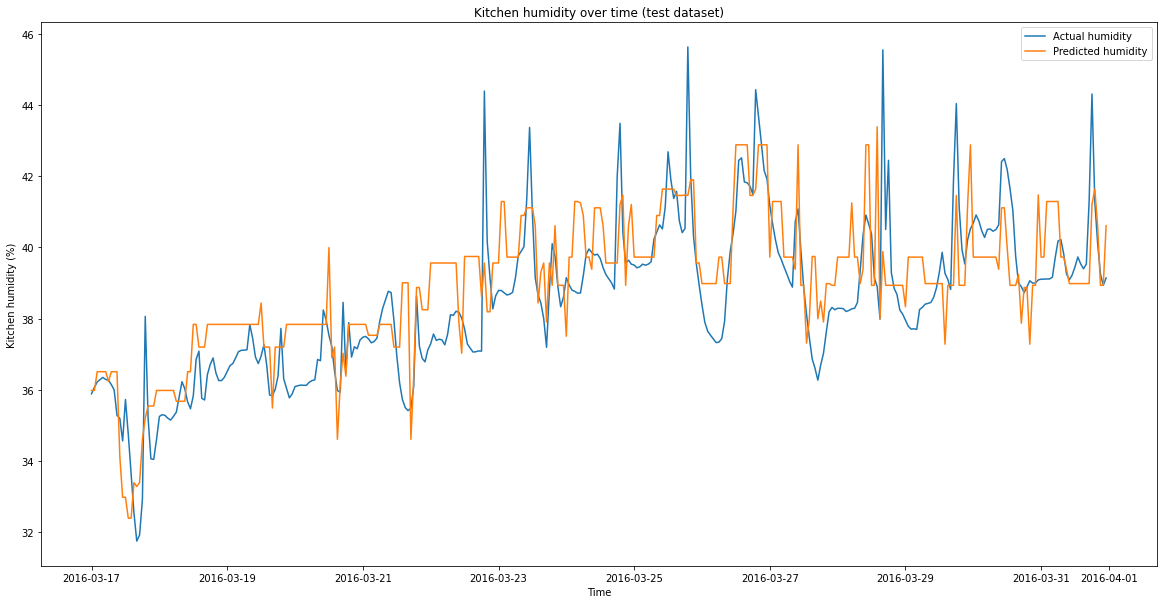

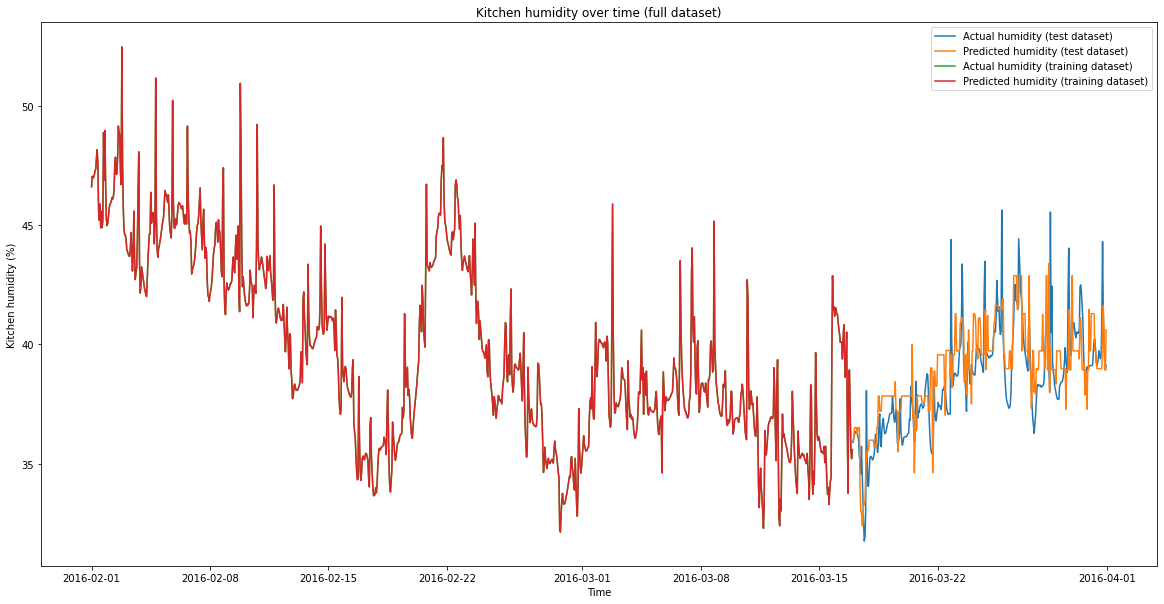

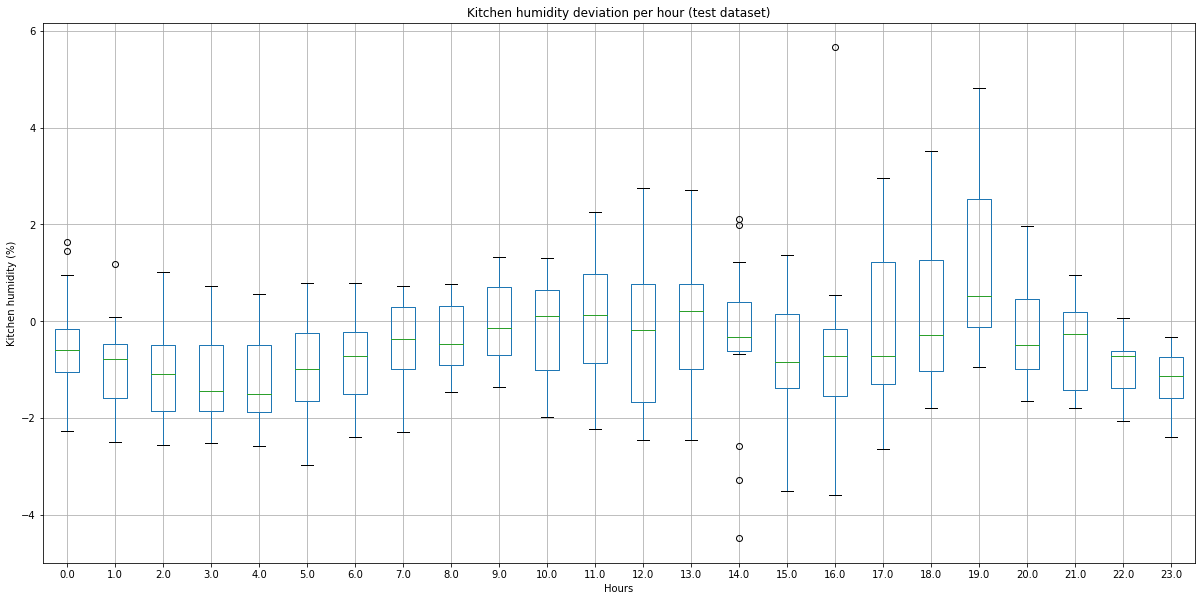

In [10]:
# Create a baseline decision tree regressor and evaluate it
model = DecisionTreeRegressor(random_state=0)

model = create_baseline_model(model, X_train, y_train, X_test, y_test)

The top plot visualises the true and predicted humidity values in function of the time on the test set over approximately two weeks. We that a general upward trend is correctly predicted by the model based on the features even though this trend wasn't really present in the training data. A test score of 0.479 is already obtained with a relatively low error in humidity of 1.551%. This can be recognised in the graph. Although the model is able to predict some smaller fluctuations, the actual bigger peaks cannot. However, sometimes similar peaks are predicted where they do not occur.<br>
A score of 1 and RMSE of 0 indicate that the tree is fitting the training data perfectly. This can also be observed in the second graph. There is good chance the baseline model is actually overfitting the data and picking up noisy features. This might be resolved by applying model selection in the next step.<br>
When looking at the third graph displaying the deviation between the actual and predicted humidity in the test set for every hour, we observe that in general the percentage is overestimate slightly but underestimated for the peak at 19h.

We now select the best parameters for the decision tree regressor based on the training data using time series cross-validation. We sample 1000 configurations from the grid where we consider the following hyperparameters: splitting method,
tree depth, minimum leaf samples, amount of features to consider at every split and the amount of leaf nodes.

In [ ]:
# Do a randomised grid search for the best parameters and evaluate the selected model
parameters = {
	"decisiontreeregressor__splitter": ["best", "random"],  # Split using the squared error criterion or randomly
	"decisiontreeregressor__max_depth": [4, 8, 10, 12, 14, None],  # Maximum depth of the tree
	"decisiontreeregressor__min_samples_leaf": [1, 4, 8, 10, 12],  # Minimum number of samples required a leaf
	"decisiontreeregressor__max_features": [None, "log2", "sqrt"],
	# Number of features to consider when looking for the best split
	"decisiontreeregressor__max_leaf_nodes": [20, 30, 40, 50, 60, None],  # Maximum number of leaf nodes
}

model = randomize_grid_search(model, parameters, X_train, y_train, X_test, y_test, iterations=1000)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits



KeyboardInterrupt



By looking at the cross-validation RMSE, we can notice that a simpler, more regularised decision tree is able to generalise better on a dataset of this size. This is accomplished by reducing the tree depth, samples per leave and amount of leaves.<br>
When this model is trained on the full training set it achieves an increased test score of 0.554 and reduced humidity error  of 1.434%. This is a decrease in RMSE of more than 0.1%. Looking at the graph of the test set only, this is perceived by more conservative predictions. The model predicts more flat surfaces (a result of returning the average humidity in a leaf) and is able to recognise potential peaks. However, it avoids predicting wrong extreme humidity values in contrast to the baseline model.<br>
The regularised model doesn't fit the training data perfectly anymore but comes really close with a training score of  0.949. In the second graph this is recognisable by the fact that the predicted training humidities are less erratic.<br>
When looking at the error in humidity per hour, we now see that the humidities are not overestimated as much anymore although the underestimation at 19h is still present with a big variance in deviation.

### The K-Nearest Neighbours Regressor

The previous experiment is repeated for the k-nearest neighbours regressor. We first establish a baseline model again without configuration.

Training score: 0.945, Test score: 0.040
Training RMSE: 0.908 Test RMSE: 2.105


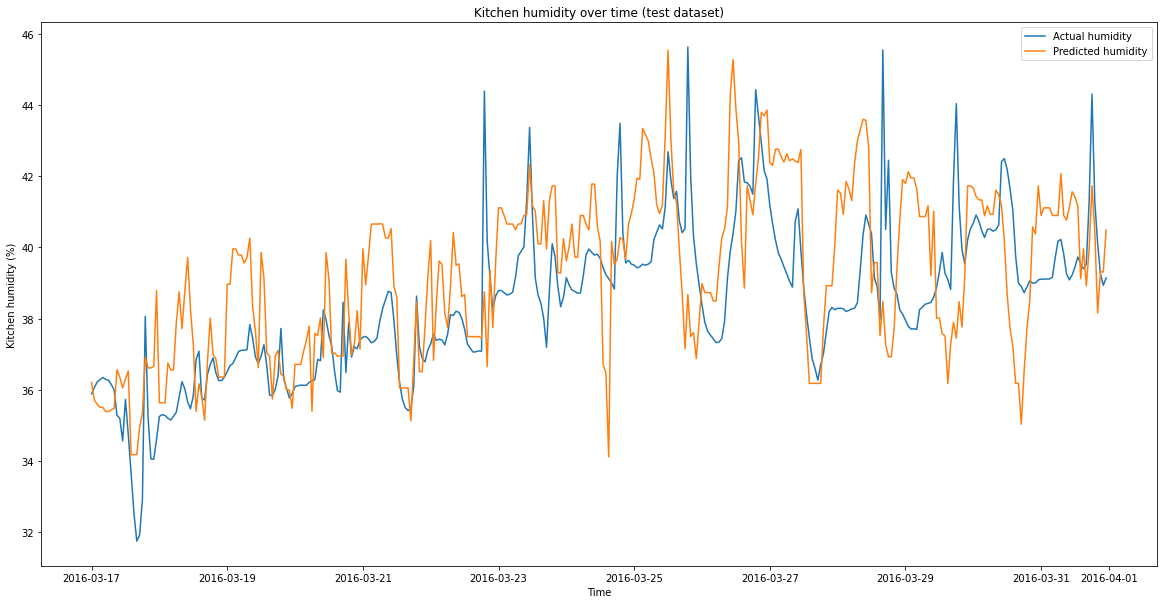

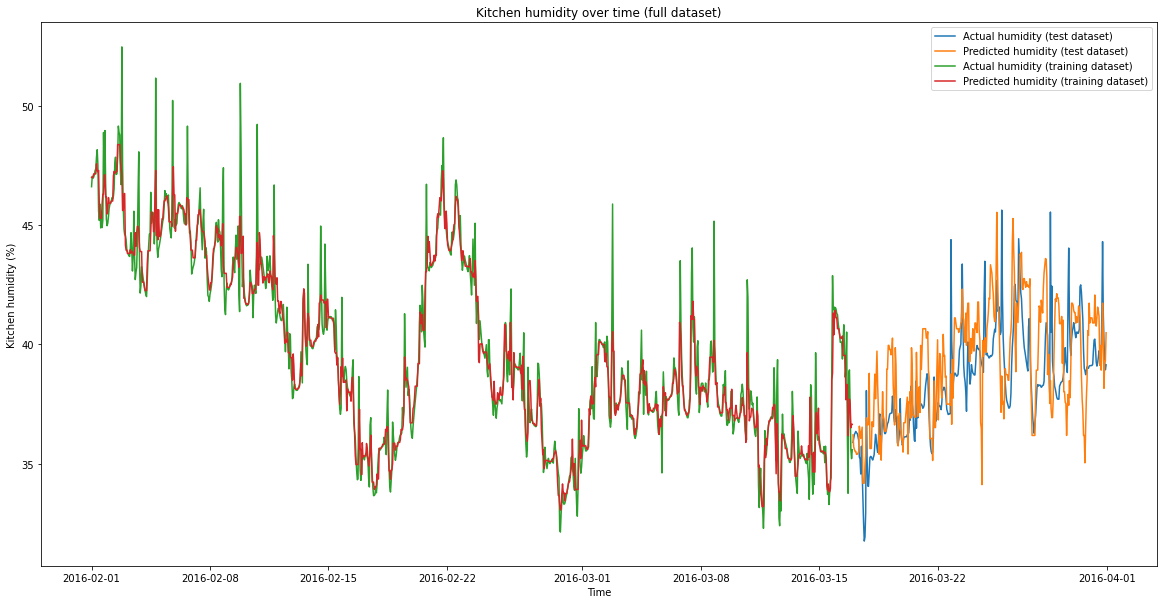

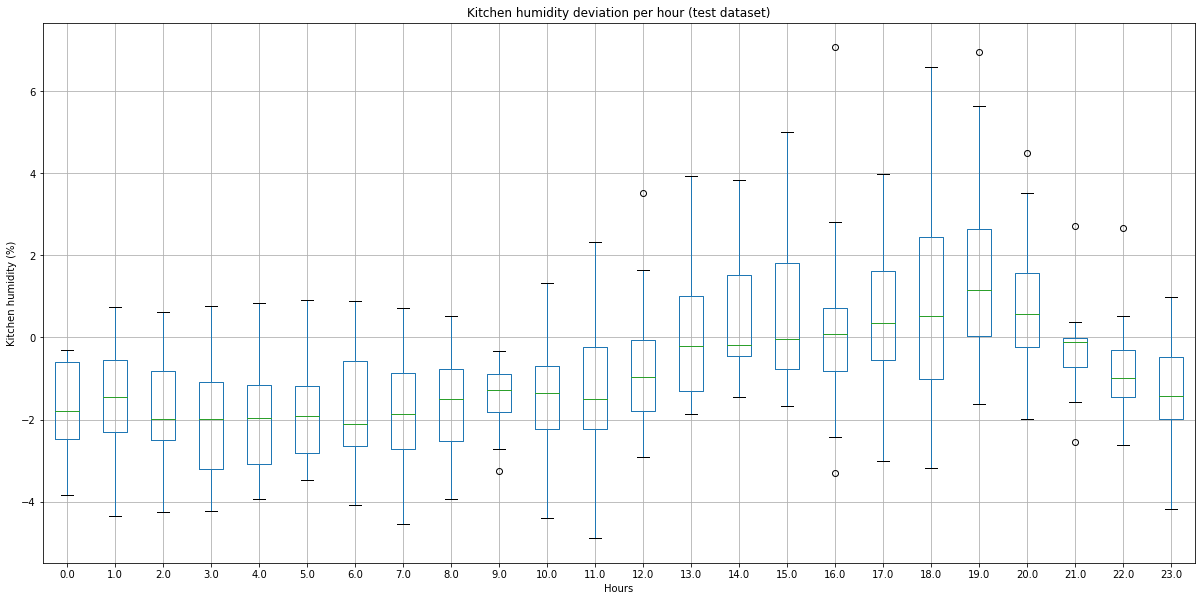

In [12]:
# Create a baseline K-Nearest Neighbors regressor and evaluate it
model = KNeighborsRegressor()

model = create_baseline_model(model, X_train, y_train, X_test, y_test)

As is clear from the first graph, this baseline nearest neighbours model is much more susceptible to the noise present in the training data. As a consequence the model's test score is only 0.040, barely better than predicting the mean training humidity. The RMSE is above 2% humidity. The predictions on the test set contain multiple big unwarranted peaks and are less in line with the general upward trend.<br>
Looking at the predictions on the training set, we see that this model doesn't fit the humidity values perfectly (not surprising given that the default amount of neighbours is 5) but comes really close. The outlying humidity values are not fitted.<br>
Similar to the decision tree regressor, the third graph shows that the median hourly prediction is too low while the humidity peaks around 19h are underestimated.

In a similar fashion, we do parameter selection by randomly sampling 1000 parameter configurations from the grid and validating them with cross-validation. We consider the parameters relating to the amount of neighbours, the weighting of the neighbours, the power parameter for the Minkowski metric used, the type of tree datastructure to find the neighbours and the leave size within this tree.

In [13]:
# Do a randomised grid search for the best parameters and evaluate the selected model
parameters = {
	"kneighborsregressor__n_neighbors": [1, 2, 5, 10, 20, 50, 60],  # Number of neighbours to consider
	"kneighborsregressor__algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
	# The algorithm and datastructure to find the neigbours
	"kneighborsregressor__weights": ["uniform", "distance"],  # The weight function used in the prediction
	"kneighborsregressor__leaf_size": [1, 2, 5, 10, 15, 20],  # The leaf size of the tree
	"kneighborsregressor__p": [1, 2, 3, 4],  # The power of the Minkowski distance metric
}

model = randomize_grid_search(model, parameters, X_train, y_train, X_test, y_test, iterations=1000)

OSError: [Errno 22] Invalid argument

The best parameter set obtained through selection has a root-mean-square error of 2.089% humidity. Surprisingly, this configured model does fit the training set perfectly which can be observed in the second graph. This can be explained by the chosen parameter settings. Instead of uniformly weighting the importance of the neighbours, the influence of the points on the prediction is weighted by the inverse of their distance. This is combined with a Manhattan-distance instead of Euclidean distance and the amount of neighbours to be considered is increased.<br>
In this way, the tuned model achieves a slightly increased score of 0.089, still not much better than predicting the mean. But by looking at the graph of the testing set, we see that less extreme jumps in humidity are now avoided although large fluctuations remain that are not always present in reality. This could be explained by the many jumps present in the dataset for which the Manhattan-distance is close to the test features.<br>
The humidity deviation per hour is very similar to the baseline model, although the variance in deviation has reduced slightly.

### Conclusion

We can conclude that for this dataset of in-house measurements and weather data, a decision tree regressor model selected through cross-validation generalises better to future predictions of humidity percentages than a k-nearest neighbour regressor selected through the same process. <br>
The nature and inner workings of the two regression machine learning models express themselves in their future predictions.
The predictions of the decision tree regressor were smoother with fewer peaks and contained multiple flat surfaces when the depth of the tree was limited. The k-nearest neighbour regressor on the other hand, was much more susceptible to large fluctuations and noise and it's predictions on the test set, although not correct, resembled more the actual values in the training set.<br>
The nature of time series predictions in which we mainly try to extrapolate from the training data in the past, makes it so that similar measurements are less relevant than in a standard regression problem. This could potentially explain the poor testing accuracy of the nearest neighbours model.<br>
We have observed that for both regression algorithms, the untuned baseline model's testing accuracy could be increased through parameter selection with time-series cross-validation. In the case of the decision tree this resulted in a more regularised model that overfitted less. For the k-nearest neighbour model, this was not as obviously visible as the training error actually disappeared while the testing predictions became more stable too.<br>
In conclusion, our experiments indicated that the decision tree regressor is a better fit for this type of time series forecasting problem for this particular dataset and behaviour of predicted variable. The prediction accuracy of the model could potentially be improved by preprocessing the data further and removing redundant features. Cross-validation is not only important to model selection but can help in evaluating these rather manual decisions too.